Our team is interested in tackling the OpenVaccine Kaggle competition (https://www.kaggle.com/c/stanford-covid-vaccine) by developing a neutrual network model to predict COVID-19 mRNA vaccine degradation. Train set provides 2400 RNA sequences, and each sequence has three RNA structure features (structure, reactivity, predicted loop type) and five ground truths that evaluated through experiments (deg_pH10, deg_Mg_pH10, deg_50C, deg_Mg_50C, reactivity) and their correponding errors. The goal of this competiton is to use RNA structural features to predict the degradation rates at each base of RNA sequence at three experimental conditions, including reactivity, deg_Mg_pH10, and deg_Mg_50C.

The additional challenge is problem in this exercise is the different size of training and testing target. We have decided to focus on the public test (see below) to simply the issue. If time permits, we will look to address the bigger sized target prediction.

In [11]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics


# SK-learn library for importing the newsgroup data.

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.model_selection import train_test_split

import nltk

# Tools for counting letters in the sequences
from collections import Counter as count
import plotly.express as px

### Mounting Google Drive


In [88]:

from google.colab import drive
drive.mount('/content/drive')

### Load the train data

In [40]:
full_train = pd.read_json('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/train.json', lines=True)
full_train = full_train.set_index(keys='index')
full_train.info()
full_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2400 non-null   object 
 1   sequence             2400 non-null   object 
 2   structure            2400 non-null   object 
 3   predicted_loop_type  2400 non-null   object 
 4   signal_to_noise      2400 non-null   float64
 5   SN_filter            2400 non-null   int64  
 6   seq_length           2400 non-null   int64  
 7   seq_scored           2400 non-null   int64  
 8   reactivity_error     2400 non-null   object 
 9   deg_error_Mg_pH10    2400 non-null   object 
 10  deg_error_pH10       2400 non-null   object 
 11  deg_error_Mg_50C     2400 non-null   object 
 12  deg_error_50C        2400 non-null   object 
 13  reactivity           2400 non-null   object 
 14  deg_Mg_pH10          2400 non-null   object 
 15  deg_pH10             2400 non-null   o

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
index,,,,,,,,,,,,,,,,,,
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


### Load the test data

In [35]:
full_test = pd.read_json('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/test.json', lines=True)
full_test = full_test.set_index(keys='index')
full_test.info()
full_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634 entries, 0 to 3633
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   3634 non-null   object
 1   sequence             3634 non-null   object
 2   structure            3634 non-null   object
 3   predicted_loop_type  3634 non-null   object
 4   seq_length           3634 non-null   int64 
 5   seq_scored           3634 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 198.7+ KB


,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
index,,,,,,
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Start EDA here

First, we start with sanity check. According to competition description, the test set is a mixture of 'private test' and 'public test' data, differ by the length of RNA sequence (seq_length). Here we separate the test set into two sets. 

In [41]:
public_test = full_test[full_test.seq_length==107].reset_index()
private_test = full_test[full_test.seq_length==130].reset_index()
print(public_test.shape)
print(private_test.shape)

(629, 7)
(3005, 7)


Checking the training data as with quick descrption.


In [42]:
include =['object', 'float', 'int']
descriptive_summary = full_train.describe(include = include)

descriptive_summary

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,2400,2400,2400,2400,2400.000000,2400.000000,2400.0,2400.0,2400,2400,2400,2400,2400,2400,2400,2400,2400,2400
unique,2400,2400,1507,1530,NaN,NaN,NaN,NaN,2394,2394,2389,2390,2387,2395,2394,2391,2392,2385
top,id_a5b113d5a,GGAAAACCAGAUGCGAGCUAGAUUCAUUUGAGGCCCAAGGCCCAAA...,.................................................,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...,NaN,NaN,NaN,NaN,"[146151.225, 146151.225, 146151.225, 146151.22...","[104235.1742, 104235.1742, 104235.1742, 104235...","[314833.5695, 314833.5695, 314833.5695, 314833...","[171525.3217, 171525.3217, 171525.3217, 171525...","[271158.604, 271158.604, 271158.604, 271158.60...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
freq,1,1,278,278,NaN,NaN,NaN,NaN,6,6,10,9,13,6,6,10,9,15
mean,NaN,NaN,NaN,NaN,4.530456,0.662083,107.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,2.835142,0.473099,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,-0.103000,0.000000,107.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2.391000,0.000000,107.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,4.442500,1.000000,107.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.294250,1.000000,107.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is structured quite complicated with different length for sequences can be different in different data set, so just double check that length is expected. 

In [43]:
def check_seq_length (data,seq, expected_length):
  return data.apply(lambda x:len(x[seq]) == x[expected_length], axis = 1)

for seq in ['sequence', 'structure', 'predicted_loop_type']: 
  print(f'Is the length for {seq} as expected?', all(check_seq_length(full_train, seq, 'seq_length')))


for seq in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']: 
  print(f'Is the length for {seq} as expected?', all(check_seq_length(full_train, seq, 'seq_scored')))



Is the length for sequence as expected? True
Is the length for structure as expected? True
Is the length for predicted_loop_type as expected? True
Is the length for reactivity as expected? True
Is the length for deg_Mg_pH10 as expected? True
Is the length for deg_pH10 as expected? True
Is the length for deg_Mg_50C as expected? True
Is the length for deg_50C as expected? True


In [44]:
# Function to plot correlation matricies
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

RNA contains four bases and form G-C and A-U paris. COVID-19 mRNA vaccine is single-stranded RNA and it forms pairs as it floats and folds itself. Among the two pair types, G-C pair tends to be more statble than A-U pair due to the bonding strength. Therefore, the higher weight of G and C bases in a RNA will make RNA less degradable. Furthermore, structure and loop type also affects RNA degradation. Unpaired bases are more vulnerable to temperature and UV challenges. Stem stucture tend to be more stable tham loops.
Below, we are exploring the weight of each base in each RNA sequence, weight of possible pairings, and weight of different structure types. 

What is the fraction of each base in each observation? 




In [45]:
# Count the fraction of all the bases in the sequences
bases = []

for base in range(len(full_train)):
    counts = dict(count(full_train.iloc[base]['sequence']))
    bases.append((
        counts['A'] / 107,
        counts['G'] / 107,
        counts['C'] / 107,
        counts['U'] / 107
    ))
    
bases = pd.DataFrame(bases, columns=['A_percent', 'G_percent', 'C_percent', 'U_percent'])
bases

,A_percent,G_percent,C_percent,U_percent
0,0.420561,0.177570,0.214953,0.186916
1,0.233645,0.308411,0.299065,0.158879
2,0.401869,0.224299,0.186916,0.186916
3,0.261682,0.327103,0.327103,0.084112
4,0.542056,0.056075,0.056075,0.345794
...,...,...,...,...
2395,0.439252,0.205607,0.168224,0.186916
2396,0.672897,0.056075,0.196262,0.074766
2397,0.299065,0.252336,0.271028,0.177570
2398,0.448598,0.233645,0.158879,0.158879


In [46]:
include =['object', 'float', 'int']
base_summary = bases.describe(include = include)

base_summary

,A_percent,G_percent,C_percent,U_percent
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.396024,0.231476,0.212671,0.159829
std,0.098092,0.069180,0.065449,0.078637
min,0.168224,0.037383,0.056075,0.018692
25%,0.336449,0.196262,0.177570,0.112150
50%,0.392523,0.233645,0.214953,0.158879
75%,0.439252,0.271028,0.252336,0.186916
max,0.719626,0.485981,0.485981,0.588785


Of the 4 bases, A has the highest average prevalence while U is the least prevalent on average.

What is fraction of each base pair in each observation? 

In [47]:
pairs = []
all_partners = []
for base in range(len(full_train)):
  partners = [-1 for symbol in range(130)]
  pairs_dict = {('U', 'G'): 0, ('C', 'G'): 0, ('U', 'A'): 0, ('G', 'C'): 0, ('A', 'U'): 0, ('G', 'U'): 0}
  queue = []
  for symbol in range(0, len(full_train.iloc[base]['structure'])):
    if full_train.iloc[base]['structure'][symbol] == '(':
      queue.append(symbol)
    if full_train.iloc[base]['structure'][symbol] == ')':
      first = queue.pop()
      pairs_dict[(full_train.iloc[base]['sequence'][first], full_train.iloc[base]['sequence'][symbol])] += 1
      partners[first] = symbol
      partners[symbol] = first
  
  all_partners.append(partners)
  
  pairs_num = 0
  pairs_unique = [('U', 'G'), ('C', 'G'), ('U', 'A'), ('G', 'C'), ('A', 'U'), ('G', 'U')]
  for item in pairs_dict:
    pairs_num += pairs_dict[item]
  add_tuple = list()
  for item in pairs_unique:
    add_tuple.append(pairs_dict[item]/pairs_num)
  pairs.append(add_tuple)
    
pairs = pd.DataFrame(pairs, columns=['U-G', 'C-G', 'U-A', 'G-C', 'A-U', 'G-U'])
full_train['partners'] = all_partners
pairs

,U-G,C-G,U-A,G-C,A-U,G-U
0,0.086957,0.130435,0.260870,0.347826,0.173913,0.000000
1,0.030303,0.363636,0.030303,0.393939,0.121212,0.060606
2,0.041667,0.208333,0.208333,0.291667,0.125000,0.125000
3,0.000000,0.437500,0.062500,0.406250,0.031250,0.062500
4,0.000000,0.000000,0.457143,0.000000,0.542857,0.000000
...,...,...,...,...,...,...
2395,0.000000,0.210526,0.263158,0.263158,0.157895,0.105263
2396,0.142857,0.000000,0.428571,0.142857,0.285714,0.000000
2397,0.000000,0.294118,0.235294,0.323529,0.147059,0.000000
2398,0.133333,0.200000,0.066667,0.400000,0.200000,0.000000


In [48]:
include =['object', 'float', 'int']
pair_summary = pairs.describe(include = include)

pair_summary

,U-G,C-G,U-A,G-C,A-U,G-U
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.042692,0.275058,0.172464,0.285677,0.179940,0.044169
std,0.059855,0.124409,0.104418,0.119615,0.106006,0.063148
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.105263,0.208333,0.111111,0.000000
50%,0.032258,0.277778,0.166667,0.285714,0.166667,0.029412
75%,0.066667,0.354839,0.230769,0.363636,0.240000,0.068966
max,0.428571,0.714286,0.714286,0.857143,0.714286,0.571429


Looking at the base pairs, on average, the G-C pair is the most prevalent while the U-G pair is the least

What are the total counts of base pairs in the whole training set?

In [49]:
pairs_dict = {('U', 'G'): 0, ('C', 'G'): 0, ('U', 'A'): 0, ('G', 'C'): 0, ('A', 'U'): 0, ('G', 'U'): 0}
queue = []
for base in range(len(full_train)):
  observation = full_train.iloc[base]
  for symbol in range(len(observation['structure'])):
    if observation['structure'][symbol] == '(':
      queue.append(symbol)
    if observation['structure'][symbol] == ')':
      first = queue.pop()
      pairs_dict[(observation['sequence'][first], observation['sequence'][symbol])] += 1

                
pairs_dict

{('A', 'U'): 9961,
 ('C', 'G'): 15797,
 ('G', 'C'): 16336,
 ('G', 'U'): 2439,
 ('U', 'A'): 9955,
 ('U', 'G'): 2280}

In [50]:
names = []
values = []
for item in pairs_dict:
    names.append(item)
    values.append(pairs_dict[item])
    
df = pd.DataFrame()
df['pair'] = names
df['count'] = values
df['pair'] = df['pair'].astype(str)

fig = px.bar(
    df, 
    x='pair', 
    y="count", 
    orientation='v', 
    title='Pair types', 
    height=400, 
    width=800
)
fig.show()

In the predicted loop type column, the following symbols were used to represent
base pair categories.

S: paired "Stem"

M: Multiloop

I: Internal loop 

B: Bulge

H: Hairpin loop 

E: dangling End 

X: eXternal loop 

What is the fraction of each category in each observation?

In [51]:
loops = []
for prediction in range(len(full_train)):
    counts = dict(count(full_train.iloc[prediction]['predicted_loop_type']))
    types = ['E', 'S', 'H', 'B', 'X', 'I', 'M']
    row = []
    for item in types:
      if item in counts:
        row.append(counts[item] / 107)
      else:
        row.append(0)
    loops.append(row)
    
loops = pd.DataFrame(loops, columns=types)
loops

,E,S,H,B,X,I,M
0,0.242991,0.429907,0.140187,0.009346,0.046729,0.130841,0.000000
1,0.242991,0.616822,0.102804,0.009346,0.000000,0.000000,0.028037
2,0.242991,0.448598,0.140187,0.000000,0.009346,0.112150,0.046729
3,0.252336,0.598131,0.130841,0.018692,0.000000,0.000000,0.000000
4,0.242991,0.654206,0.074766,0.028037,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2395,0.271028,0.355140,0.214953,0.000000,0.112150,0.046729,0.000000
2396,0.831776,0.130841,0.037383,0.000000,0.000000,0.000000,0.000000
2397,0.242991,0.635514,0.112150,0.000000,0.000000,0.000000,0.009346
2398,0.242991,0.280374,0.112150,0.000000,0.327103,0.037383,0.000000


Looking at the loop type summaries, on average, S is the most prevalent type at 44.21% and B is the least present at 1.12%.

In [52]:
include =['object', 'float', 'int']
loops_summary = loops.describe(include = include)

loops_summary

,E,S,H,B,X,I,M
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.333466,0.442118,0.111464,0.011947,0.030993,0.047457,0.022555
std,0.189512,0.149079,0.054053,0.023233,0.063634,0.060182,0.052779
min,0.196262,0.130841,0.037383,0.000000,0.000000,0.000000,0.000000
25%,0.242991,0.387850,0.074766,0.000000,0.000000,0.000000,0.000000
50%,0.252336,0.485981,0.102804,0.000000,0.009346,0.028037,0.000000
75%,0.280374,0.542056,0.140187,0.009346,0.028037,0.084112,0.018692
max,0.831776,0.710280,0.514019,0.177570,0.495327,0.392523,0.336449


In [53]:
res_dict = {'E':0, 'S':0, 'H':0, 'B':0, 'X':0, 'I':0, 'M':0}
for prediction in range(len(full_train)):
    observation = full_train.iloc[prediction]
    pred_symbol = dict(count(observation['predicted_loop_type']))
    for item in pred_symbol:
      if item in pred_symbol:
        res_dict[item] += pred_symbol[item]

res_dict

{'B': 3068,
 'E': 85634,
 'H': 28624,
 'I': 12187,
 'M': 5792,
 'S': 113536,
 'X': 7959}

In [54]:
names = []
values = []
for item in res_dict:
    names.append(item)
    values.append(res_dict[item])
    
df = pd.DataFrame()
df['loop_type'] = names
df['count'] = values

In [55]:
fig = px.bar(
    df, 
    x='loop_type', 
    y="count", 
    orientation='v', 
    title='Predicted loop types', 
    height=400, 
    width=600
)
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



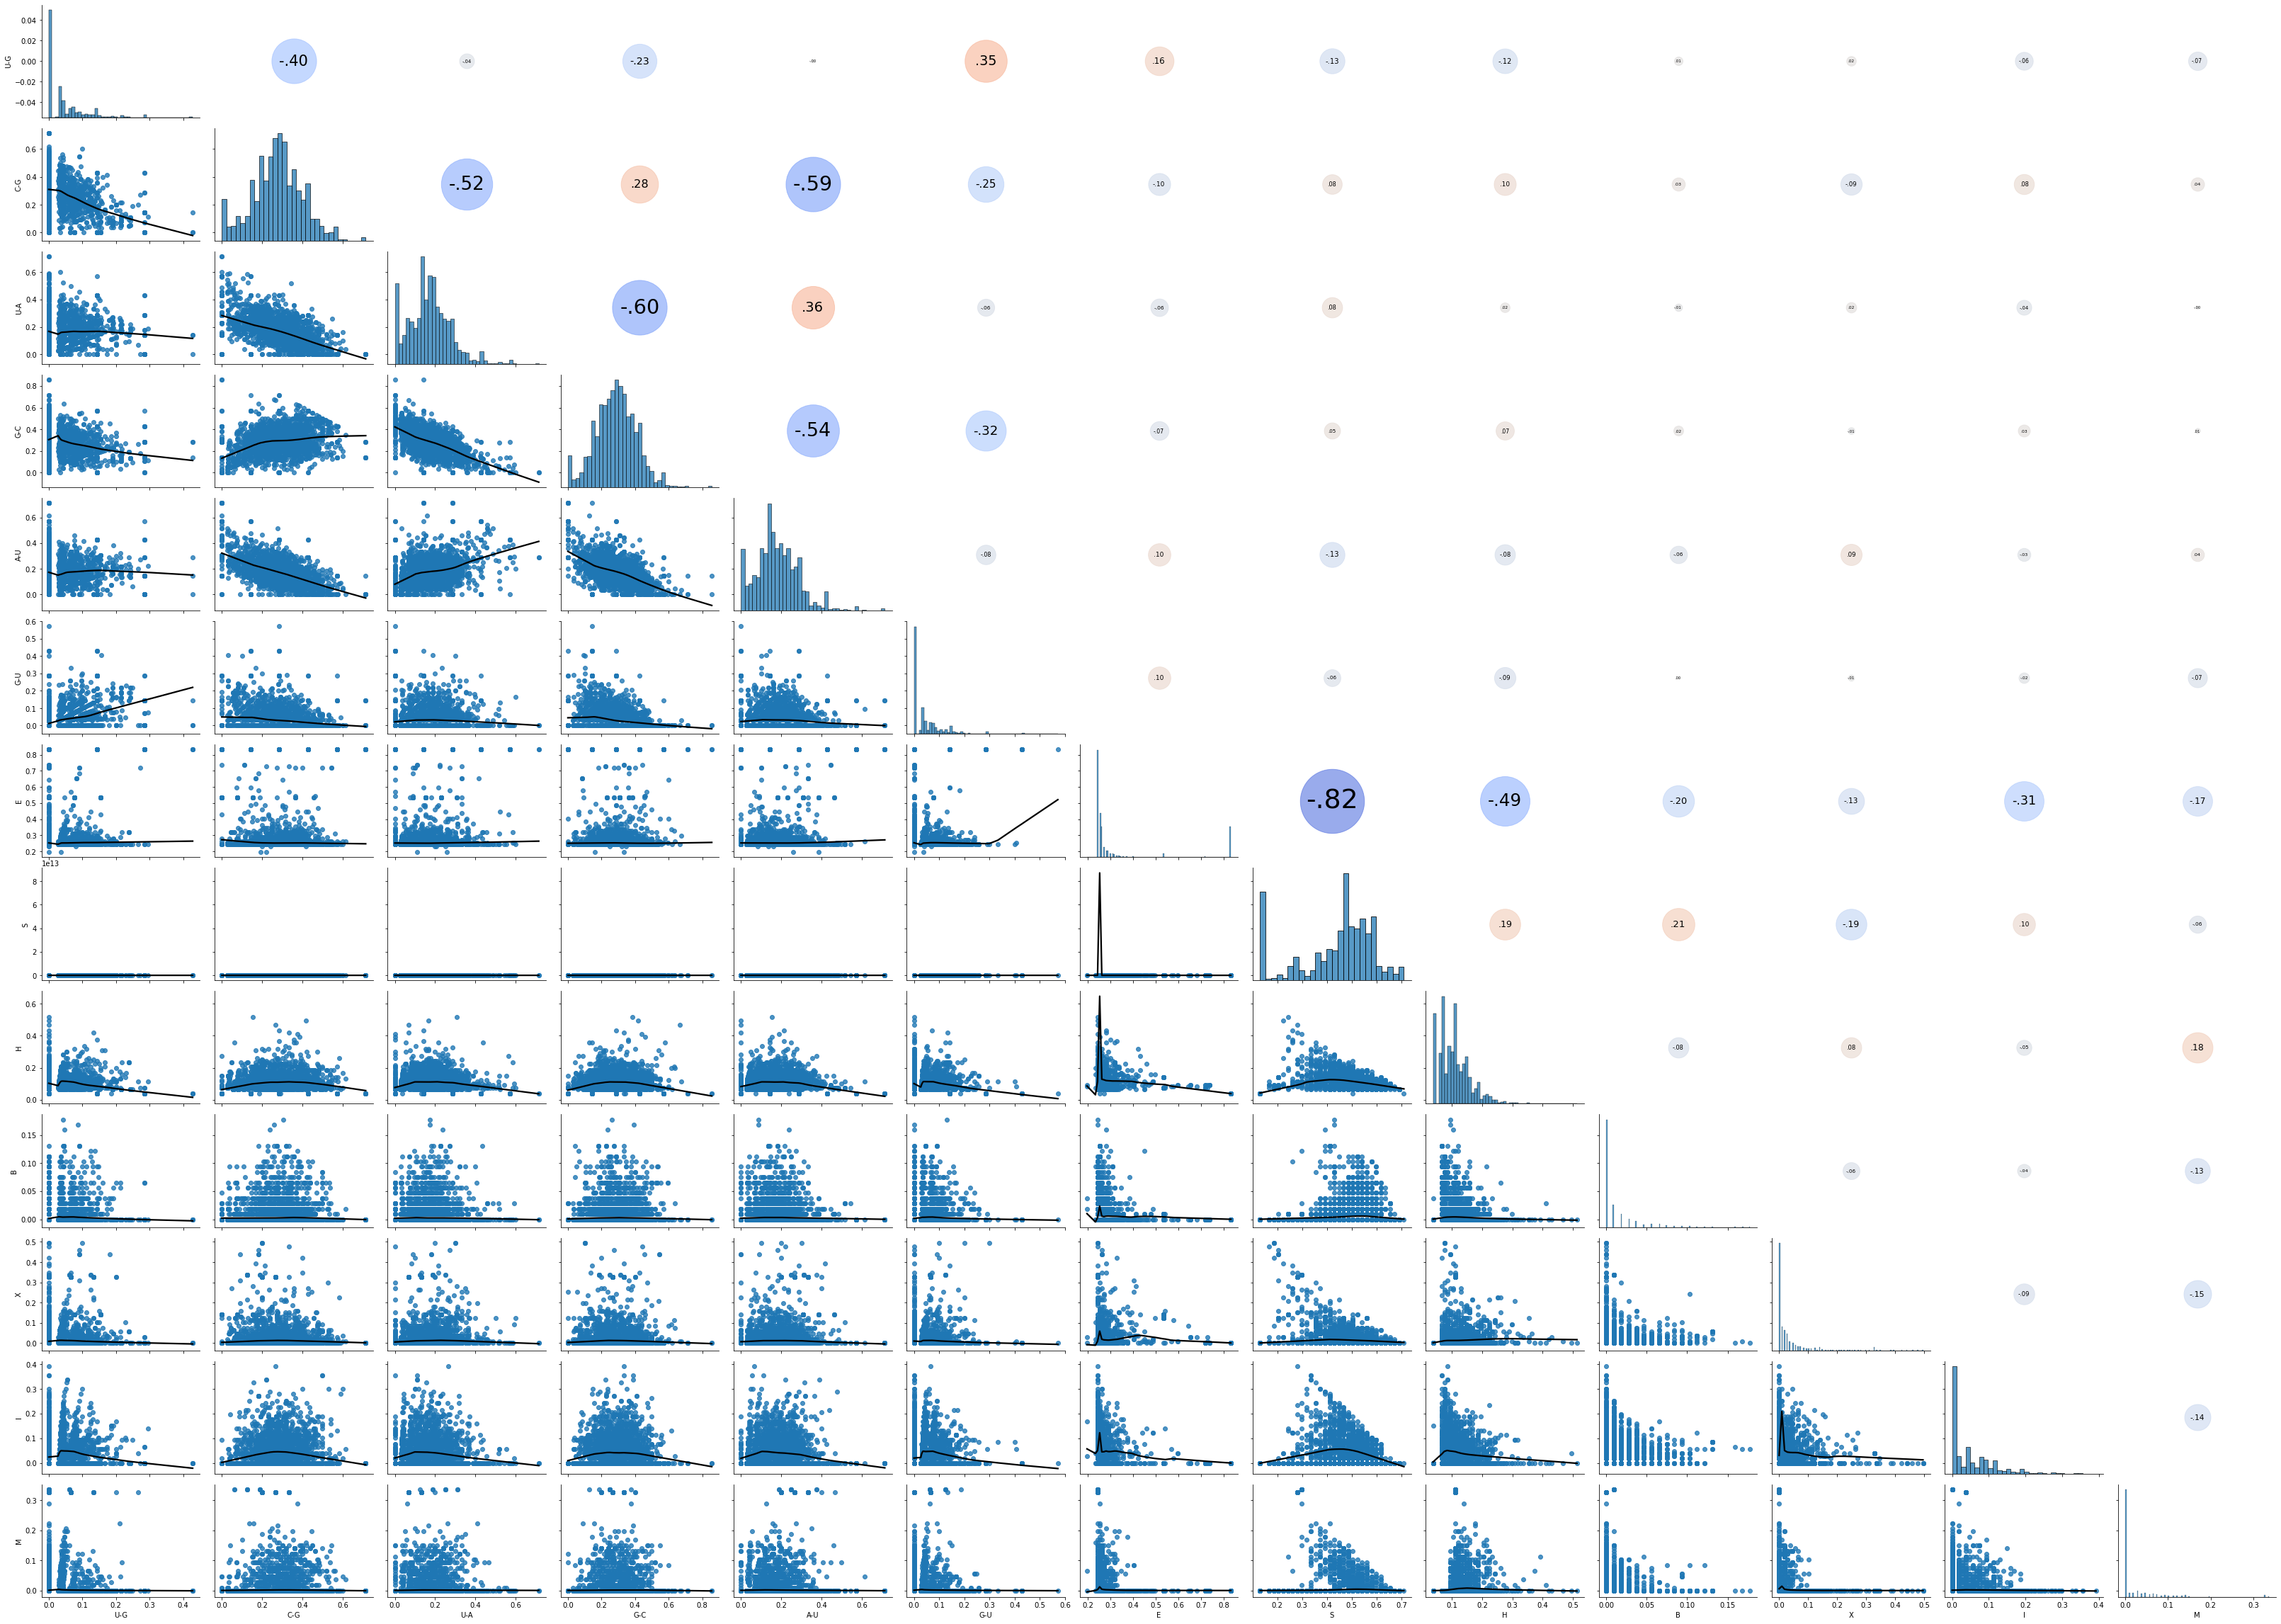

In [56]:
#pairs and loops
pairs.reset_index(drop=True, inplace=True)
loops.reset_index(drop=True, inplace=True)

correlation_frame = pd.concat([pairs, loops], axis=1)
correlation_frame

g = sns.PairGrid(correlation_frame, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

Looking at correlations between base pairs and loop types, we see a high correlation of -.82 between loop types E and S. It looks like there may be an strong grouping of data anchoring this relationship. There is also a strong inverse relationship of -.60 between U-A and G-C pairs.

Signal to noise ratio exploration

In [57]:
fig = px.histogram(
    full_train, 
    "signal_to_noise", 
    nbins=25, 
    title='signal_to_noise histogram', 
    width=700,
    height=500
)
fig.show()

In [58]:
ds = full_train['SN_filter'].value_counts().reset_index()
ds.columns = ['SN_filter', 'count']
fig = px.pie(
    ds, 
    values='count', 
    names="SN_filter", 
    title='SN_filter pie chart', 
    width=500, 
    height=500
)
fig.show()

Looking for correlation in the means of the prediction targets showed us correlation among the observations/samples. For example, observations with a higher mean deg_50_Mg_50C had a higher meand deg_ph10. This relationship should be further explored at the individual base level. 



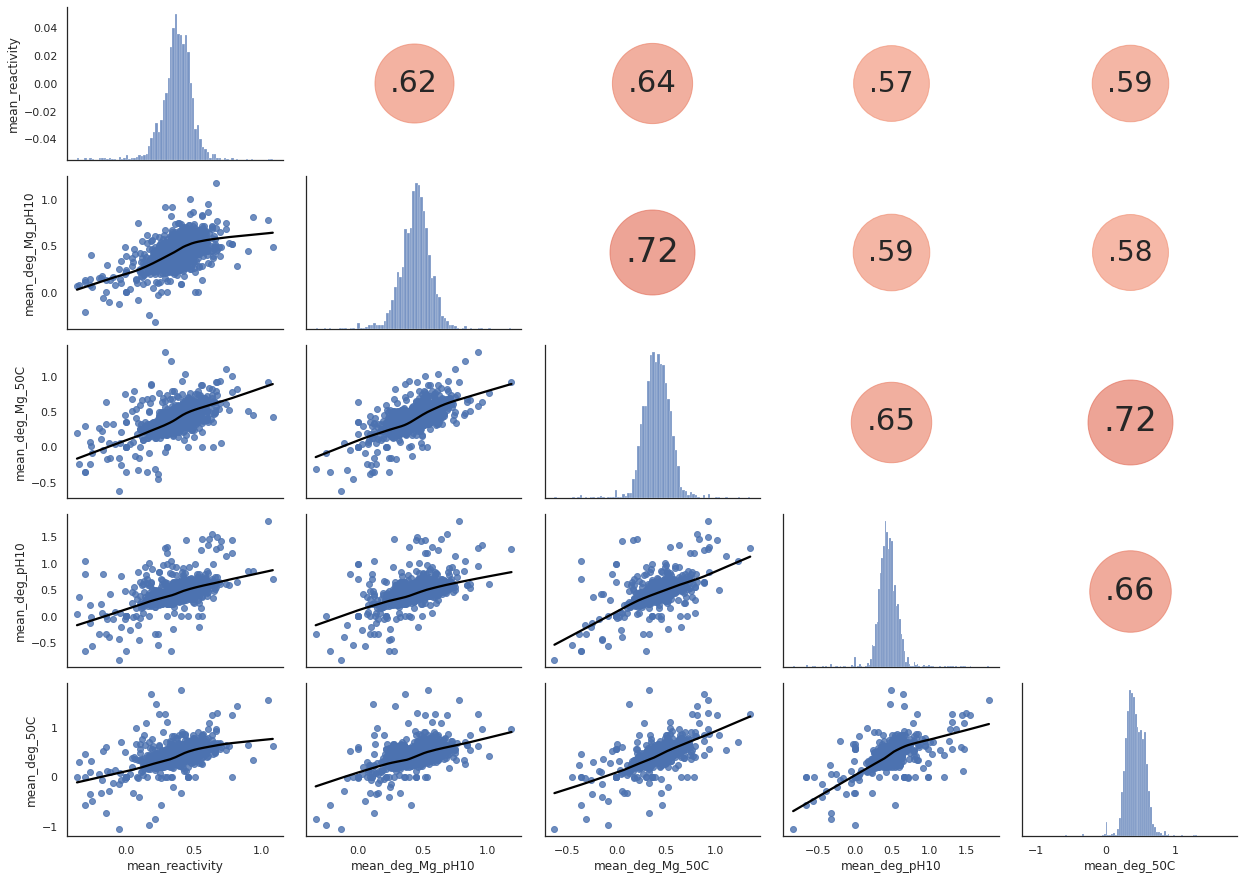

In [59]:
full_train['mean_reactivity'] = full_train['reactivity'].apply(lambda x: np.mean(x))
full_train['mean_deg_Mg_pH10'] = full_train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
full_train['mean_deg_Mg_50C'] = full_train['deg_Mg_50C'].apply(lambda x: np.mean(x))
full_train['mean_deg_pH10'] = full_train['deg_pH10'].apply(lambda x: np.mean(x))
full_train['mean_deg_50C'] = full_train['deg_50C'].apply(lambda x: np.mean(x))

full_train_plots = full_train.iloc[:,19:25]

full_train_plots

sns.set(style='white', font_scale=1)
g = sns.PairGrid(full_train_plots, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

## Start modeling here

### Feature creation

In this problem, our initial input variables are RNA sequence, structure, and loop types, which are represented by characters. The models can not directly consuming those features and we will need to convert them into a numerical format.  

In [60]:

# Create an dictionary to map character to a integer
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def tokenise(data, dic):

  """
  Function to convert sequence, structure and predited_loop_type into one long numerical 
  feature array for each RNA sample 
  """

  # grab the data 
  temp = list(data.sequence) + list(data.structure) +list(data.predicted_loop_type)
  temp = np.array(temp)

  # creating mapping array 
  k = np.array(list(dic.keys()))
  v = np.array(list(dic.values()))

  # Get argsort indices
  sidx = k.argsort()

  # map the initial array to integers 
  ks = k[sidx]
  vs = v[sidx]
  return vs[np.searchsorted(ks,temp)]

# apply the function to train and test data 
full_train['feature_array'] = full_train.apply(lambda x: tokenise(x, token2int), axis = 1)
public_test['feature_array'] =public_test.apply(lambda x: tokenise(x, token2int), axis = 1)

In [61]:
# Checking if the shape is as expected 
np.array(full_train['feature_array'].tolist()).shape

(2400, 321)

In [62]:
 # split into a training, a dev and and a test data
 train_data, dev_test = train_test_split(
    full_train, test_size=.2, random_state=34)
 
dev_data, test_data = train_test_split(
    dev_test, test_size=.5, random_state=34)

dev_data.shape 
train_data.shape

(1920, 25)

In [63]:
train_data

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,partners,mean_reactivity,mean_deg_Mg_pH10,mean_deg_Mg_50C,mean_deg_pH10,mean_deg_50C,feature_array
index,,,,,,,,,,,,,,,,,,,,,,,,,
158,id_0ff370c27,GGAAACGCGCUGGUGCGAGCGGCGGCGGCGAAAGCCGCCGAAAGGC...,.....((((((((((((((((.(.(((((....)))(((....)))...,EEEEESSSSSSSSSSSSSSSSISISSSSSHHHHSSSSSSHHHHSSS...,0.757,0,107,68,"[0.4146, 1.1616, 0.7542, 0.5522, 0.5455, 0.582...","[0.47150000000000003, 0.8623000000000001, 1.13...","[1.4243000000000001, 2.1015, 1.7458, 1.7685, 0...","[1.2576, 1.5789, 0.895, 1.1526, 0.836100000000...","[1.1185, 2.0241, 1.9323000000000001, 1.8859, 2...","[-0.13, 2.419, 0.8159000000000001, 0.2684, 0.2...","[-0.0927, 0.329, 1.5119, 0.0, 0.3685, -0.0916,...","[0.37470000000000003, 3.0535, 2.298, 2.6984, 0...","[0.8582000000000001, 2.5436, 0.441, 1.25470000...","[-0.2412, 0.7436, 0.9587, 0.9353, 1.7836, 2.26...","[-1, -1, -1, -1, -1, 66, 65, 64, 63, 62, 61, 6...",0.290125,0.373829,0.440591,0.574079,0.560075,"[5, 5, 3, 3, 3, 4, 5, 4, 5, 4, 6, 5, 5, 6, 5, ..."
988,id_68954ba34,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.928,1,107,68,"[0.1077, 0.1568, 0.12660000000000002, 0.1063, ...","[0.16620000000000001, 0.2636, 0.167, 0.1502, 0...","[0.1774, 0.18760000000000002, 0.1095, 0.097700...","[0.1101, 0.1564, 0.1332, 0.1037, 0.0922, 0.102...","[0.1451, 0.1811, 0.1519, 0.12240000000000001, ...","[0.4892, 1.7883, 1.287, 0.9163, 0.6269, 0.7779...","[0.3801, 1.8715000000000002, 0.7084, 0.5785, 0...","[2.1592000000000002, 3.0822, 1.008, 0.7792, 0....","[0.5123, 1.8083, 1.4862, 0.8773000000000001, 0...","[0.6525000000000001, 1.7371, 1.3942, 0.8553000...","[-1, -1, -1, -1, -1, 66, 65, 64, 63, -1, 61, 6...",0.483249,0.616279,0.597243,0.570762,0.571551,"[5, 5, 3, 3, 3, 5, 6, 5, 4, 6, 4, 3, 5, 3, 6, ..."
680,id_479d5a9b0,GGAAAUAGCAGGCGAACGAACAAGACUGGAAAGCAGCGCGAGGGAA...,........(..(((...........(((.....))))))..).......,EEEEEEEESIISSSBBBBBBBBBBBSSSHHHHHSSSSSSIISXXXX...,5.566,1,107,68,"[0.146, 0.2169, 0.15360000000000001, 0.1425000...","[0.187, 0.2604, 0.08460000000000001, 0.1367000...","[0.2434, 0.302, 0.0956, 0.137, 0.1858000000000...","[0.1519, 0.2696, 0.0766, 0.1476, 0.1811, 0.125...","[0.2157, 0.29560000000000003, 0.1422, 0.1741, ...","[0.4706, 1.5268000000000002, 0.9766, 0.8245, 1...","[0.7082, 1.9824000000000002, 0.120900000000000...","[2.0882, 3.568, 0.2296, 0.6672, 1.7421, 0.9636...","[0.5659000000000001, 3.2675, 0.1545, 1.0207, 1...","[1.0098, 2.3827, 0.5855, 0.9681000000000001, 1...","[-1, -1, -1, -1, -1, -1, -1, -1, 41, -1, -1, 3...",0.402484,0.466315,0.500749,0.523591,0.497513,"[5, 5, 3, 3, 3, 6, 3, 5, 4, 3, 5, 5, 4, 5, 3, ..."
447,id_2e8f990ee,GGAAAAGGAUCCCUAUGGAGCUGGGAUCUAGAGCGAAAGCUCUAGA...,......((((((((((((((((((((((((((((....))))))))...,EEEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSS...,0.054,0,107,68,"[10.8925, 14.2024, 10.783, 7.8524, 5.3808, 5.3...","[73705.3986, 73705.3986, 73705.3986, 73705.398...","[31.2931, 26.3985, 16.5922, 16.5922, 16.5922, ...","[121286.7182, 121286.7182, 121286.7182, 121286...","[20.2091, 20.2091, 20.2091, 20.2091, 26.3502, ...","[0.0, 6.8892, 6.8893, 2.0668, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.9041, 7.4202, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 12.7817, 0.0, 0.0, 0.0, 0...","[-1, -1, -1, -1, -1, -1, 65, 64, 63, 62, 61, 6...",0.242560,0.307997,0.423591,0.221090,0.322672,"[5, 5, 3, 3, 3, 3, 5, 5, 3, 6, 4, 4, 4, 6, 3, ..."
686,id_481942778,GGAAAUUAACAUGAGAGAAAGAUUUAGCAAAGAUGAAGAAGAAAGA...,.................................................,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...,2.319,0,107,68,"[0.3375, 0.4974, 0.5528000000000001, 0.5371, 0...","[0.2293,

In [64]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


# train_feature = np.array(train_data['feature_array'].tolist())
# train_reactivity = np.array(train_data['reactivity'].tolist())

# dev_feature = np.array(dev_data['feature_array'].tolist())
# dev_reactivity = np.array(dev_data['reactivity'].tolist())


# clf_single = MLPRegressor()
# clf_single.fit(train_feature, train_reactivity)
# print(f'Initial model accuracy {clf_single.score(dev_feature, dev_reactivity)}')


# # def a grid search for var_smoothing 
# params = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0],
#           'hidden_layer_sizes': [(100,), (200,), (100, 100), (100, 50, 50, 50)]
#           }

# # start a grid search with min train data 
# clf = GridSearchCV(clf_single, params, cv=5)
# clf.fit(train_feature, train_reactivity)

# # get the best performing model from grid search 
# clf_best = clf.best_estimator_
# clf_best.fit(train_feature, train_reactivity)
# print(f'Final model accuracy {clf_best.score(dev_feature, dev_reactivity)}')


We are choosing to start with neural network due to the complexity of the problem. The input features are just tokenised biological representation, they are not strictly numerical nor categorical. So we think a neural network should be able to handle the complexity inside the problem. General field research and browsing through past submission also proven the choice.

In [65]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def build_nn(input_feature, output_target, params,  dev_feature, dev_target):
  """
  Training function to conduct grid search for nerual net works 
  """    

  # initiate a single ANN
  clf_single = MLPRegressor(max_iter=300, learning_rate = 'adaptive')
  # clf_single.fit(input_feature, output_target)
  # print(f'Initial model accuracy {clf_single.score(dev_feature, dev_reactivity)}')

  # def a grid search for var_smoothing 

  # start a grid search with 5 fold CV
  clf = GridSearchCV(clf_single, params, cv=5, 
                     n_jobs = 2,
                     scoring = 'neg_root_mean_squared_error')
  clf.fit(input_feature, output_target)

  # get the best performing model from grid search 
  clf_best = clf.best_estimator_
  clf_best.fit(input_feature, output_target)
  
  return clf_best

In [66]:
# start grid search for all desired outputs
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
nn_estimator = [] 
predictions = []
scores = []
        
#def a set of params to use for grid search 
params = {'alpha': [ 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 10.0],
          'hidden_layer_sizes': [(100,), (200,), (100, 100), (100, 50, 50, 50)]
          }

# prep feature 
train_feature = np.array(train_data['feature_array'].tolist())
dev_feature = np.array(dev_data['feature_array'].tolist())
test_feature = np.array(test_data['feature_array'].tolist())


for target in targets: 
  # prep the data
  output_target = np.array(train_data[target].tolist())
  dev_target = np.array(dev_data[target].tolist())
  test_target = np.array(test_data[target].tolist())


  # start grid search
  best_model = build_nn(train_feature, output_target, params,  dev_feature, dev_target)
  # save the best model
  nn_estimator +=[best_model]
  # and include prediction
  target_predict = best_model.predict(test_feature)
  predictions.append(list(target_predict))

  score = np.sqrt(metrics.mean_squared_error(test_target, target_predict))
  scores.append([score])
  print(f'Final model for {target} has RMSE: {score}')


# It takes really long time to do the gridsearch, so make some noise when it finish
import IPython
display(IPython.display.Audio(url="https://www.soundhelix.com/examples/mp3/SoundHelix-Song-14.mp3", autoplay=True))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Final model for reactivity has RMSE: 0.6251883120322631


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Final model for deg_Mg_pH10 has RMSE: 0.6011552753273706


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Final model for deg_pH10 has RMSE: 1.1589754819212676


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Final model for deg_Mg_50C has RMSE: 0.7957178427236149
Final model for deg_50C has RMSE: 1.0943536762507187


In [87]:
for target, estimator in zip(targets, nn_estimator):
  print(f'the baseline model for {target} is a {estimator.n_layers_}-layer neural network with alpha {estimator.get_params()["alpha"]}')

the baseline model for reactivity is a 4-layer neural network with alpha 10.0
the baseline model for deg_Mg_pH10 is a 4-layer neural network with alpha 10.0
the baseline model for deg_pH10 is a 3-layer neural network with alpha 10.0
the baseline model for deg_Mg_50C is a 4-layer neural network with alpha 10.0
the baseline model for deg_50C is a 6-layer neural network with alpha 0.0001


### Baseline score

We use the same metric as the competition is using to evaluate the score, a column wise root mean square error. We have used RMSE previously when selecting models from grid search, so just taking average across the column. 


In [74]:
print(f'The baseline model score is {np.average(scores)}')

The baseline model score is 0.9791649149343842


### Showing the prediction result

In [69]:
result = pd.DataFrame(dict(zip(targets, predictions)), index=test_data.id)
result.to_csv('/content/drive/MyDrive/1 MIDS/W207 Applied Machine Learning/Final Project/base_line_result.csv')

## Some thoughts on next steps
1. the best performing models in the competition submissions are variants of LSTM, which makes sense as we always want to previous bases in a sequence would matter, should we should take a look
2. the bpps data is worthy exprimenting.
3. the sequence been scored is a shorter set compared to sequence provieded, maybe we can throw away the bottom part to reduce the dimension.
4. more feature engineering, using the base pairs for e.g.
    - explore relationship of base pairs with prediction targets in more granular detail. For example are G bases associated with higher reactivity?
5. Use the competition specific scoring metric to evaluate performance.
6. We used seperate models for 5 output variables, since each output is already non-scalar, we can also try to predict all 5 output with one model.
7. The ANN are suffering from covergence warmings despite a large epoches. We could try other optimisation methods. 